In [1]:
# Import library for executing this project
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
import io
import requests
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os
import re
from os.path import isfile, join

# import libraries of python OpenCV
import cv2
from google.colab.patches import cv2_imshow # for image display

Mounted at /content/gdrive


In [2]:
# Load from Google Drive.
cap_loc = "/content/gdrive/MyDrive/CVNLP/traffic.mp4"

# Initial a variable for storing the video
cap = cv.VideoCapture(cap_loc)

In [3]:
# Display the loaded video from Google Drive
from IPython.display import HTML
from base64 import b64encode

mp4 = open(cap_loc, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

In [4]:
# Create an empty array for storing each frame in the traffic.mp4
unclean_frames = []

In [5]:
# Separate each frame and store into the empty array
while(cap.isOpened()):
  # Read the frame of the video
  ret, frame = cap.read()
  if ret == True :
    # Add each frame into the empty array
    unclean_frames.append(frame)
  else :
    break

cap.release()

In [6]:
# View the total frame extracted from traffic.mp4
print('The total extracted from the frame is : ', len(unclean_frames))

The total extracted from the frame is :  120


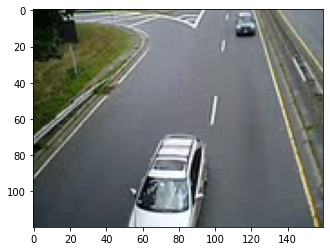

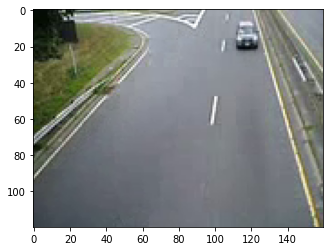

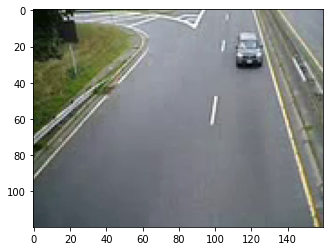

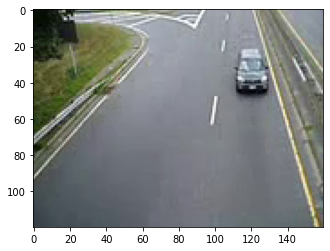

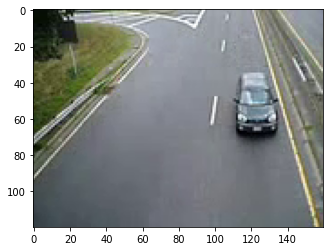

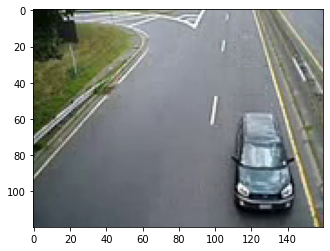

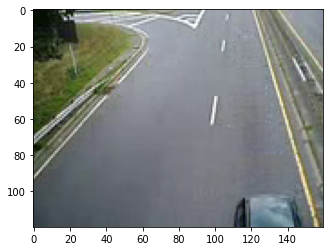

In [7]:
# Set to display the frame
z = 100

# Start lopping until the initialized frame
for i in range (z,119,3) :
  # Convert the frame's colour
  plt.imshow(cv.cvtColor(unclean_frames[i], cv.COLOR_BGR2RGB))
  # Plot the frames
  plt.show()

In [8]:
# Resize single frame that selected
resize_img = cv.resize(unclean_frames[z],(500,500),interpolation=cv.INTER_CUBIC)

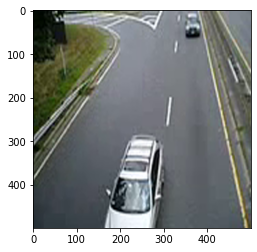

In [9]:
# Display the resized frame
plt.imshow(cv.cvtColor(resize_img, cv.COLOR_BGR2RGB))

In [10]:
# Resize the frames that had been stored in unclean_frames
resized_frames = []

def img_resize(img) : 
  for i in range (len(img)):
    resize_img = cv.resize(unclean_frames[i],(500,500),interpolation=cv.INTER_CUBIC)
    resized_frames.append(resize_img)
frames_resized = img_resize(unclean_frames)

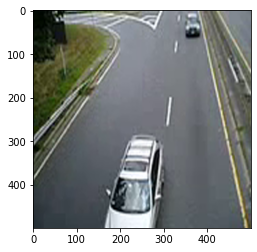

In [11]:
plt.imshow(cv.cvtColor(resized_frames[z], cv.COLOR_BGR2RGB))

In [12]:
# For adding blur to the frame
def blur_img(img,kernel_size) : 
  return cv.GaussianBlur(img,kernel_size,cv.BORDER_DEFAULT)

In [13]:
# Create a array for storing cleaned frames
cleaned_frames = []

# Function for removing noise from frame
def remove_noise(img) : 
  for i in range (len(img)) :
    # Adding blur to each frame
    blur = blur_img(img[i],(5,5))
    cleaned_frames.append(blur)
  return cleaned_frames

frames_noise_filtered = remove_noise(resized_frames)

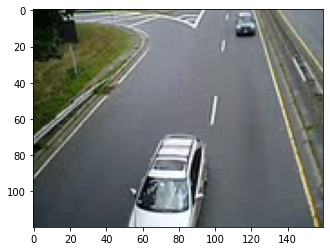

In [14]:
# Display the frame before removing noise
plt.imshow(cv.cvtColor(unclean_frames[z], cv.COLOR_BGR2RGB))

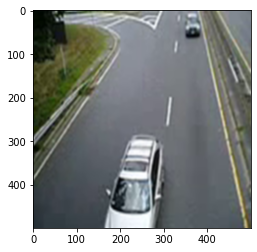

In [15]:
# Checking the frame after removed noise
plt.imshow(cv.cvtColor(cleaned_frames[z], cv.COLOR_BGR2RGB))

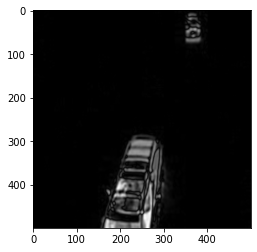

In [16]:
# Execute gray scale to the frame and select the frame from the cleaned array
grayA = cv2.cvtColor(cleaned_frames[z], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(cleaned_frames[z+1], cv2.COLOR_BGR2GRAY)

# Plot the image after frame differencing
plt.imshow(cv2.absdiff(grayB, grayA), cmap = 'gray')
plt.show()

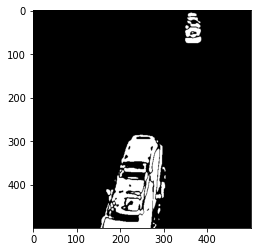

In [17]:
diff_image = cv2.absdiff(grayB, grayA)

# Perform image thresholding
ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)

# Display the frame after executing the process of thresholding
plt.imshow(thresh, cmap = 'gray')
plt.show()

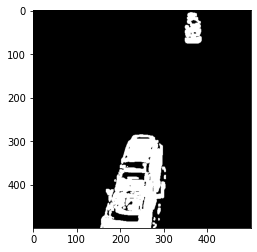

In [18]:
# Execute image dialation
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(thresh,kernel,iterations = 1)

# Display the frame after executing the dialation
plt.imshow(dilated, cmap = 'gray')
plt.show()

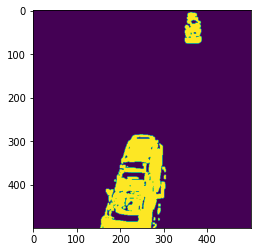

In [19]:
# plot vehicle detection zone
plt.imshow(dilated)
cv2.line(dilated, (0, 20),(256,20),(100, 0, 0))
plt.show()

In [20]:
# kernel for image dilation
kernel = np.ones((4,4),np.uint8)

# font style
font = cv2.FONT_HERSHEY_SIMPLEX

# directory to save the ouput frames
pathIn = "/content/gdrive/MyDrive/CVNLP_Final/"

for i in range(len(cleaned_frames)-1):
    
    # frame differencing
    grayA = cv2.cvtColor(cleaned_frames[i], cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(cleaned_frames[i+1], cv2.COLOR_BGR2GRAY)
    diff_image = cv2.absdiff(grayB, grayA)
    
    # image thresholding
    ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)
    
    # image dilation
    dilated = cv2.dilate(thresh,kernel,iterations = 1)
    
    # find contours
    contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    # shortlist contours appearing in the detection zone
    valid_cntrs = []
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        if (x <= 500) & (y >= 20) & (cv2.contourArea(cntr) >= 25):
            if (y >= 90) & (cv2.contourArea(cntr) < 40):
                break
            valid_cntrs.append(cntr)
            
    # add contours to original frames
    dmy = cleaned_frames[i].copy()
    cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
    
    cv2.putText(dmy, "vehicles :" + str(len(valid_cntrs)), (55, 15), font, 0.6, (0, 180, 0), 2)
    cv2.line(dmy, (0, 20),(256,20),(100, 255, 255))
    cv2.imwrite(pathIn+str(i)+'.png',dmy)  

In [21]:
# Initialize the video name after executing the AI solution
pathOut = '/content/gdrive/MyDrive/CVNLP_Final/traffic.v2.mp4'

# Set the play speed for video
fps = 14.0

In [22]:
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

In [23]:
files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in range(len(files)):
    filename=pathIn + files[i]
    
    # Read frames
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    # Inserting the frames into the created array
    frame_array.append(img)

In [24]:
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])

out.release()